# Color Fundamentals

This notebook describes a few fundamental aspects of how we perceive colors, and then proceeds to quantify a couple different colormaps in that context.

We will start by describing the color matching function, then the response function of the three cones in a human eye.  Links to data are included.  Following this, we'll demonstrate how colormaps fit into the spectrum, and how to use the package [palettable](https://jiffyclub.github.io/palettable/).

In [23]:
%matplotlib inline

In [24]:
import matplotlib.pyplot as plt
import csv
import numpy as np
plt.rcParams["figure.figsize"] = (12, 10)
plt.rcParams["figure.dpi"] = 200
plt.style.use("seaborn")

## Colors and Eyes

We'll load up the Stiles & Burch 1955 2-degree color matching functions, via http://www.cvrl.org/database/text/cmfs/sbrgb2.htm .

This will give us the chromatic responses for an observer.

In [25]:
with open("data/sbrgb2.csv") as f:
    data = [[] for _ in 'Wrgb']
    reader = csv.reader(f)
    for row in csv.reader(f):
        for l, v in zip(data, row):
            l.append(float(v))
    wavelength = np.array(data[0])
    data = np.array([data[1], data[2], data[3]])

We'll plot them now, so that we can see the wavelength and response.

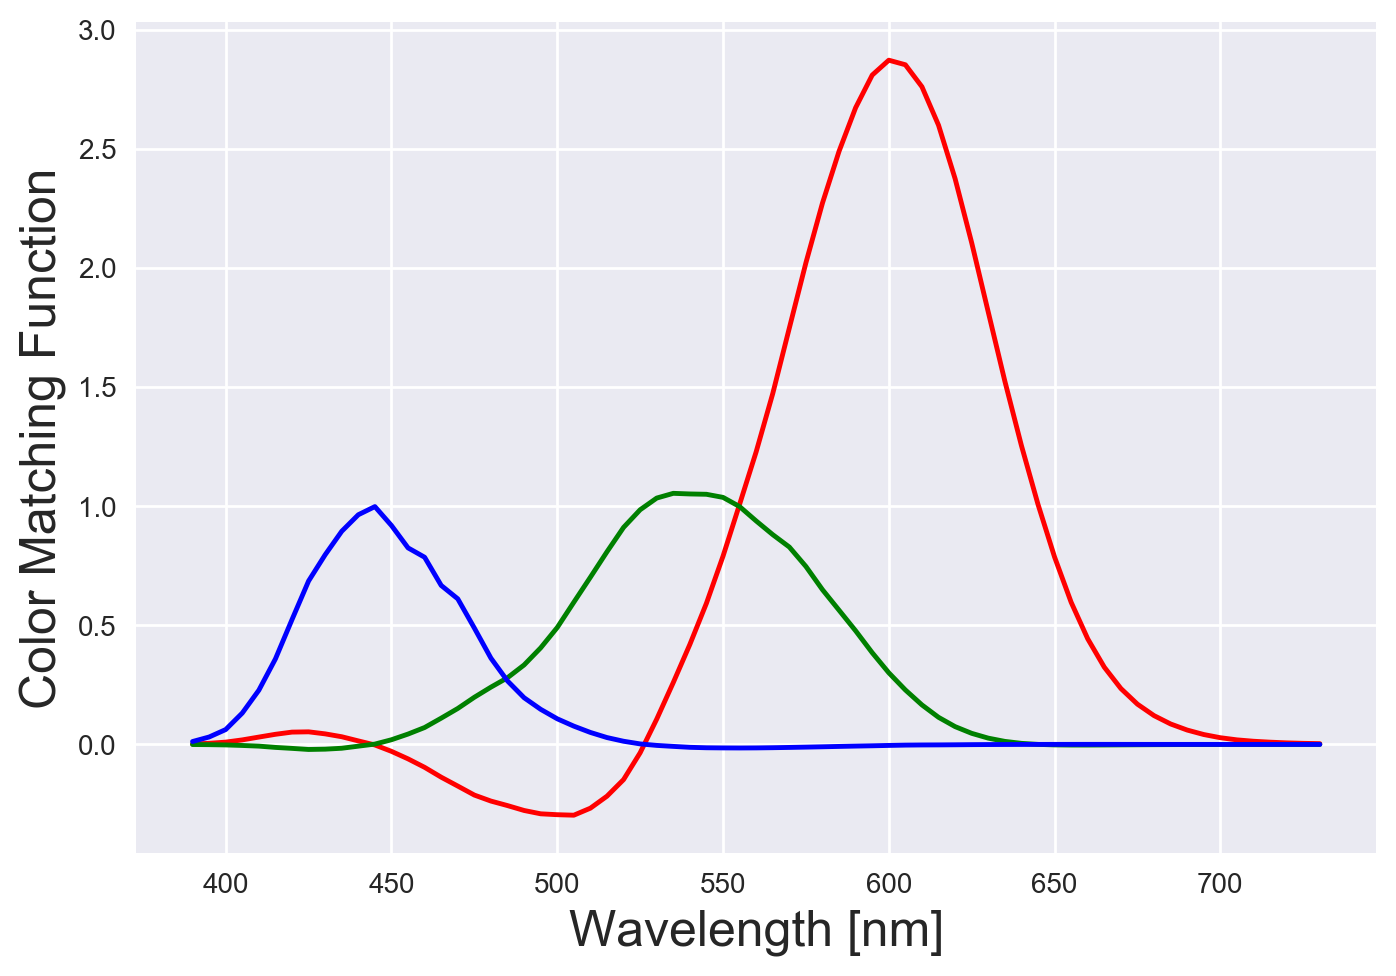

In [26]:
plt.plot(wavelength, data[0], '-r')
plt.plot(wavelength, data[1], '-g')
plt.plot(wavelength, data[2], '-b')
plt.xlabel("Wavelength [nm]", fontsize=18)
plt.ylabel("Color Matching Function", fontsize=18)
plt.savefig("images/cmf.png")

Now, let's convert these to the sensitivity of LMS.

In [27]:
# Now we convert these to LMS; Stockman, MacLeod & Johnson 1993
coeffs = np.array([
    [0.214808, 0.751035, 0.045156],
    [0.022882, 0.940534, 0.076827],
    [0.000000, 0.016500, 0.999989]
])
L, M, S = (data[0] * coeffs[i,0] 
         + data[1] * coeffs[i,1] 
         + data[2] * coeffs[i,2] for i in range(3))

We'll plot these now.

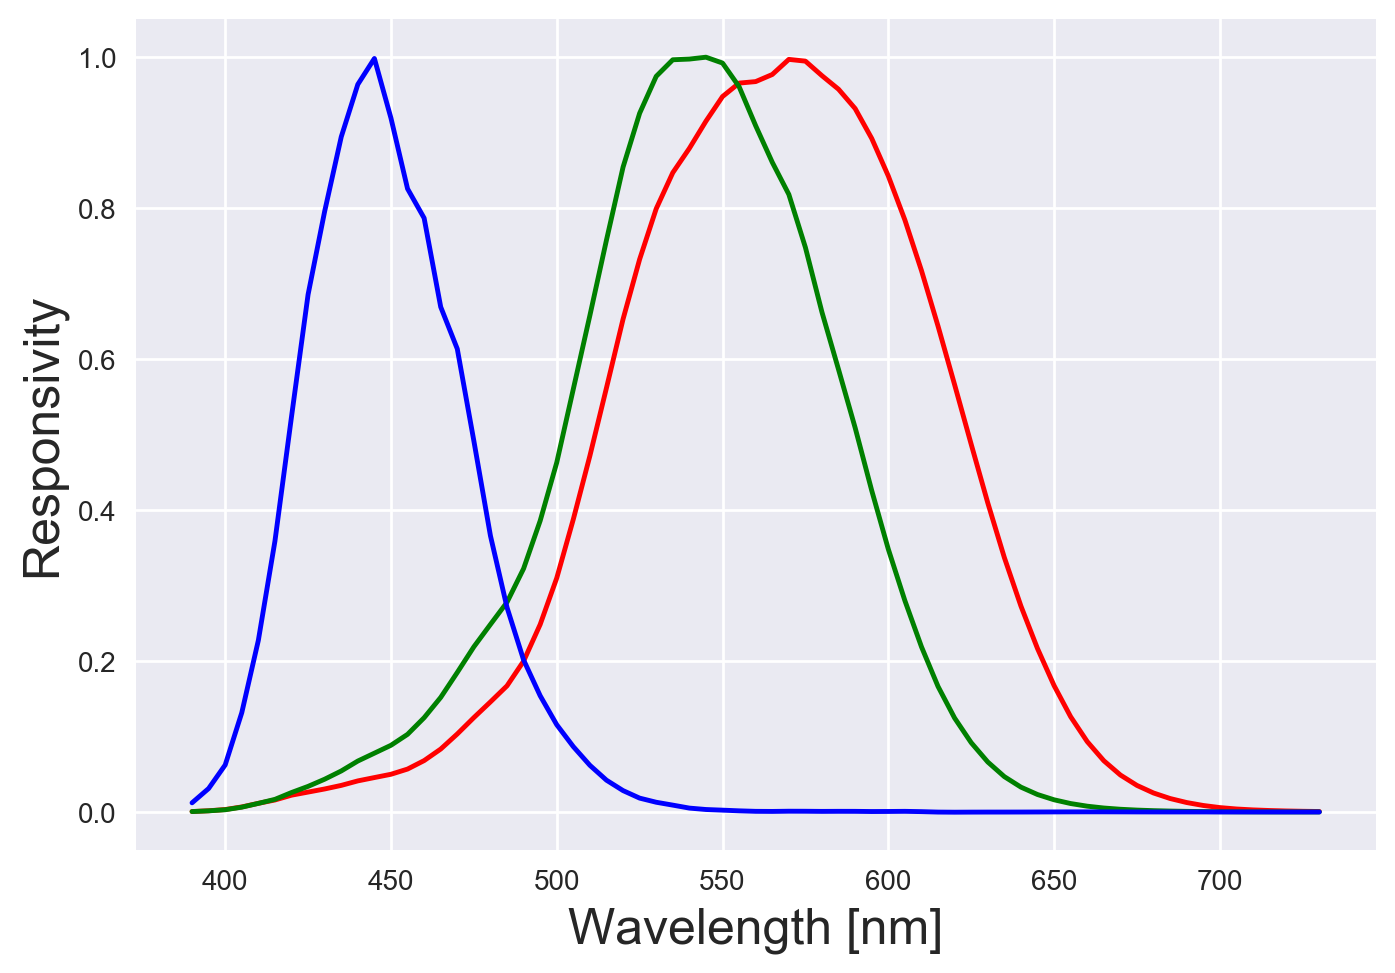

In [28]:
plt.plot(wavelength, L, '-r')
plt.plot(wavelength, M, '-g')
plt.plot(wavelength, S, '-b')
plt.xlabel("Wavelength [nm]", fontsize=18)
plt.ylabel("Responsivity", fontsize=18)
plt.savefig("images/resp.png")

Now we'll convert wavelength to RGB; this code was heavily borrowed  from http://www.noah.org/wiki/Wavelength_to_RGB_in_Python

Note that this isn't necessarily the *best* way to generate RGB curves; in fact, it does not cover the full spectrum of colors expressible in RGB.  We'll demonstrate that below.

In [29]:
wavelength = np.mgrid[wavelength[0]:wavelength[-1]:1024j]
gamma = 0.8

i1 = (wavelength >= 380) & (wavelength < 440)
i2 = (wavelength >= 440) & (wavelength < 490)
i3 = (wavelength >= 490) & (wavelength < 510)
i4 = (wavelength >= 510) & (wavelength < 580)
i5 = (wavelength >= 580) & (wavelength < 645)
i6 = (wavelength >= 645) & (wavelength < 750)

R, G, B = (np.zeros_like(wavelength) for _ in 'RGB')

a1 = attenuation = 0.3 + 0.7 * (wavelength[i1] - 380) / (440 - 380)
R[i1] = ((-(wavelength[i1] - 440) / (440 - 380)) * a1) ** gamma
G[i1] = 0.0
B[i1] = (1.0 * a1) ** gamma

R[i2] = 0.0
G[i2] = ((wavelength[i2] - 440) / (490 - 440)) ** gamma
B[i2] = 1.0

R[i3] = 0.0
G[i3] = 1.0
B[i3] = (-(wavelength[i3] - 510) / (510 - 490)) ** gamma

R[i4] = ((wavelength[i4] - 510) / (580 - 510)) ** gamma
G[i4] = 1.0
B[i4] = 0.0

R[i5] = 1.0
G[i5] = (-(wavelength[i5] - 645) / (645 - 580)) ** gamma
B[i5] = 0.0

a2 = 0.3 + 0.7 * (750 - wavelength[i6]) / (750 - 645)
R[i6] = (1.0 * a2) ** gamma
G[i6] = 0.0
B[i6] = 0.0

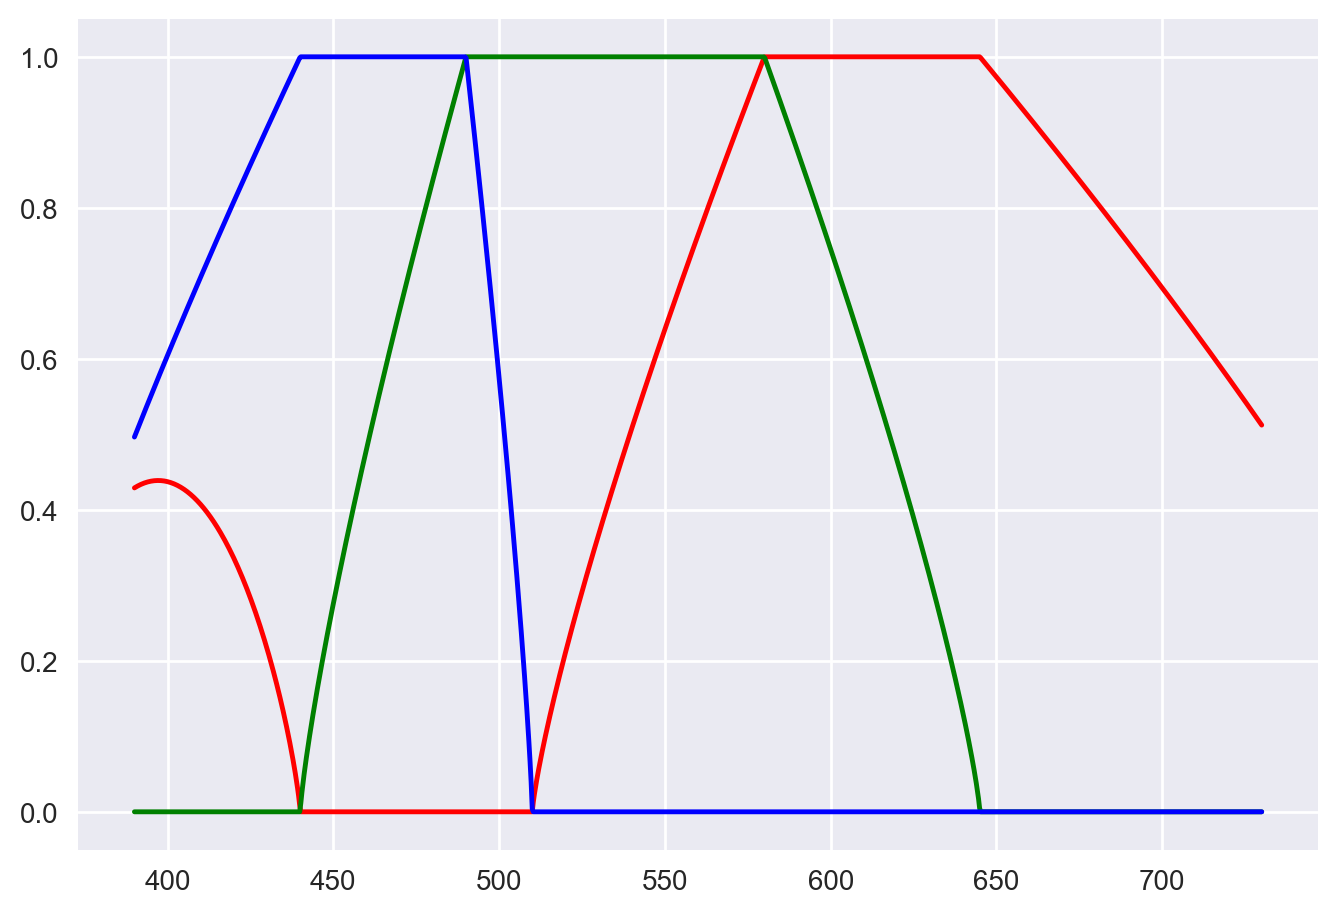

In [30]:
plt.plot(wavelength, R, '-r')
plt.plot(wavelength, G, '-g')
plt.plot(wavelength, B, '-b')

Above, you can see the RGB values as a line plot.  Below, we'll plot the RGB as a color, across these wavelengths.

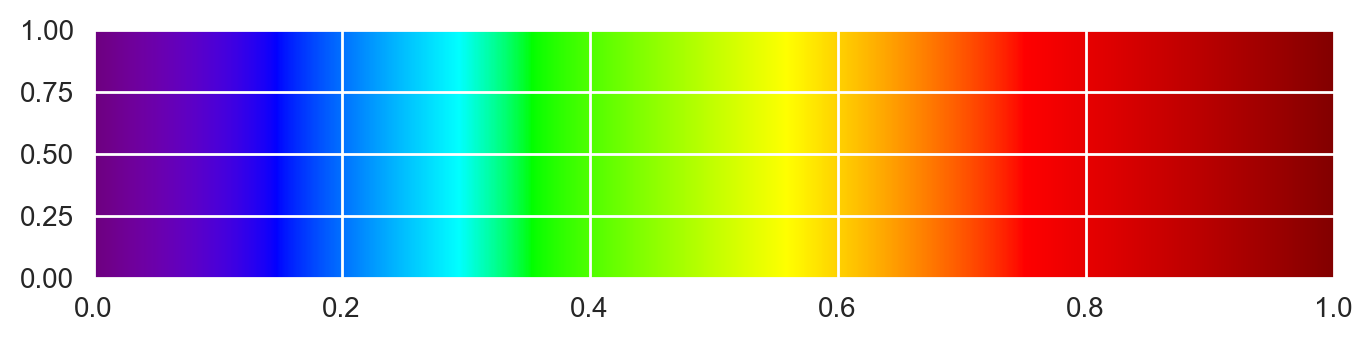

In [31]:
im = np.ones((wavelength.size, wavelength.size, 4))
im[:,:,0] *= R
im[:,:,1] *= G
im[:,:,2] *= B
im *= 255
im = im.astype("uint8")

plt.imshow(im, extent = [0.0, 1.0, 0.0, 1.0], aspect = 1.0/5)

What do some of our colormaps look like?  We'll check out viridis, which is a pretty awesome colormap.

In [32]:
import matplotlib.cm as cm

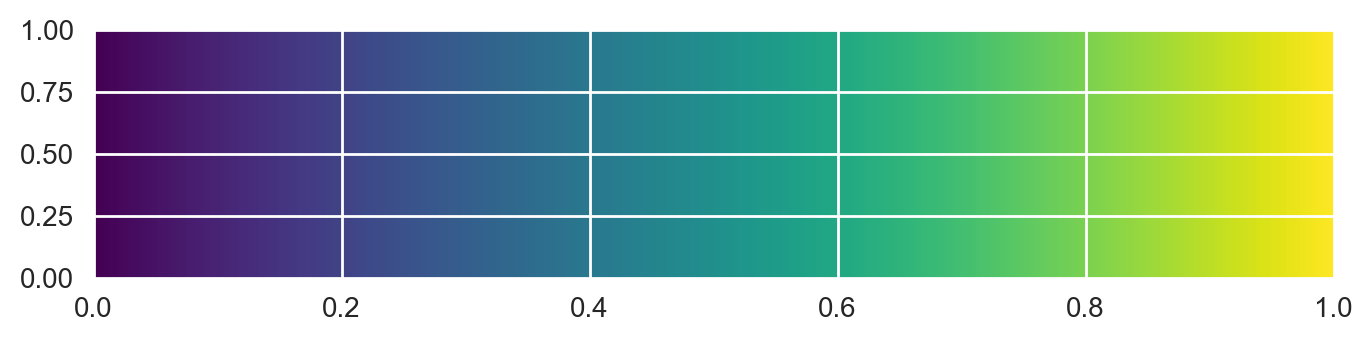

In [33]:
viridis = cm.viridis(np.mgrid[0.0:1.0:256j])[:,:3]
im = np.ones((viridis.shape[0], viridis.shape[0], 4))
im[...,:3] *= viridis[None,:,:]
im *= 255
im = im.astype("uint8")
plt.imshow(im, extent = [0.0, 1.0, 0.0, 1.0], aspect = 1.0/5)

## Colormaps

Now that is a nice looking colormap!  So what happens if we try to restrict this to the RGB values we've identified in our image above, when we generated the rainbow?  We'll try to find the "nearest" RGB values by looking at the L2 norm of the distance.

In [34]:
# Now we need to get our reversal to wavelength from an RGB value.
# We don't have that many wavelengths, so let's just do an L2 norm for each.

rgb = np.array([R,G,B]).T

def get_rgb(cmap_name):
    colors = cm.cmap_d[cmap_name](np.mgrid[0.0:1.0:256j])[:,:3]
    closest = np.sqrt(np.abs((rgb[:,None,:] - colors)**2.0).sum(axis=2)).argmin(axis=0)
    return closest
    
rgbi = get_rgb("viridis")

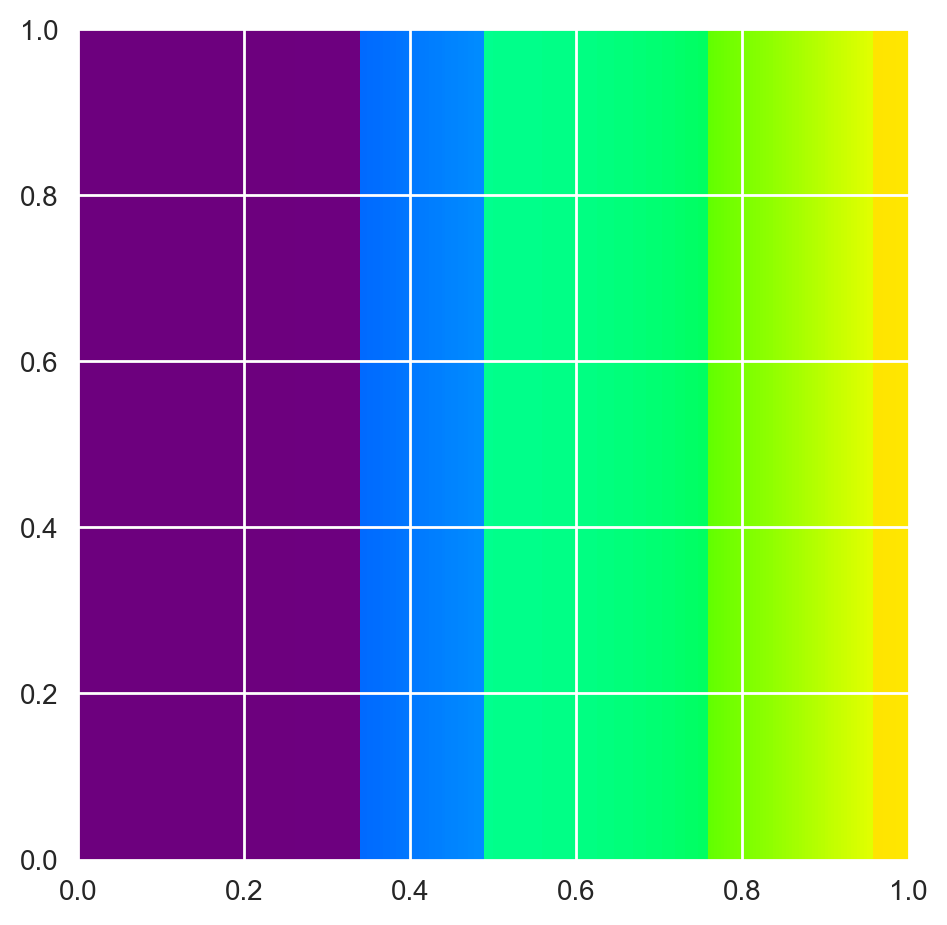

In [35]:
im = np.ones((rgbi.size, rgbi.size, 4))
im[:,:,0] *= R[rgbi]
im[:,:,1] *= G[rgbi]
im[:,:,2] *= B[rgbi]
im *= 255
im = im.astype("uint8")

plt.imshow(im, extent = [0.0, 1.0, 0.0, 1.0])

Yuck!  Not quite as nice.  The way we've generated the spectra here, where we varied a reasonably simple function along one dimension, doesn't allow for the expressiveness that we need for really nice looking colors.

We'll take a look at a couple colormaps now, to see what they look like in both color and RGB space.  The plots you'll see will have the colormap at the bottom, and in the top panel they'll show the R, G, B lines from 0 to 1, to show the relative composition.

In [36]:
def plot_rgb(cmap_name):
    N = 256
    colors = cm.cmap_d[cmap_name](np.mgrid[0.0:1.0:N * 1j])[:,:3]
    plt.clf()
    fig = plt.figure()
    ax = fig.add_axes([0.0, 0.15, 1.0, 0.8])
    plt.plot(np.mgrid[0.0:1.0:N*1j], colors[:,0], '-r')
    plt.plot(np.mgrid[0.0:1.0:N*1j], colors[:,1], '-g')
    plt.plot(np.mgrid[0.0:1.0:N*1j], colors[:,2], '-b')
    plt.xlim(0.0, 1.0)
    plt.ylim(0.0, 1.01)
    ax.xaxis.set_ticklabels([])
    ax.yaxis.set_ticklabels([])
    ax = fig.add_axes([0.0, 0.0, 1.0, 0.2])
    im = np.ones((1, N, 3), dtype="uint8")
    im *= (colors*255).astype("uint8")[None, :, :]
    ax.imshow(im, interpolation='nearest', extent = [0.0, 1.0, 0.0, 1.0], aspect = 20.0/N)
    plt.xlim(0.0, 1.0)
    ax.xaxis.set_ticklabels([])
    ax.xaxis.set_visible(False)
    ax.yaxis.set_ticklabels([])
    ax.yaxis.set_visible(False)
    plt.savefig("images/%s_colors.png" % cmap_name)

viridis is the new default colormap in matplotlib.  For a great description of how this was developed and why, see Stefan Van der Walt's [talk from SciPy 2015](https://www.youtube.com/watch?v=xAoljeRJ3lU).

<Figure size 1600x1100 with 0 Axes>

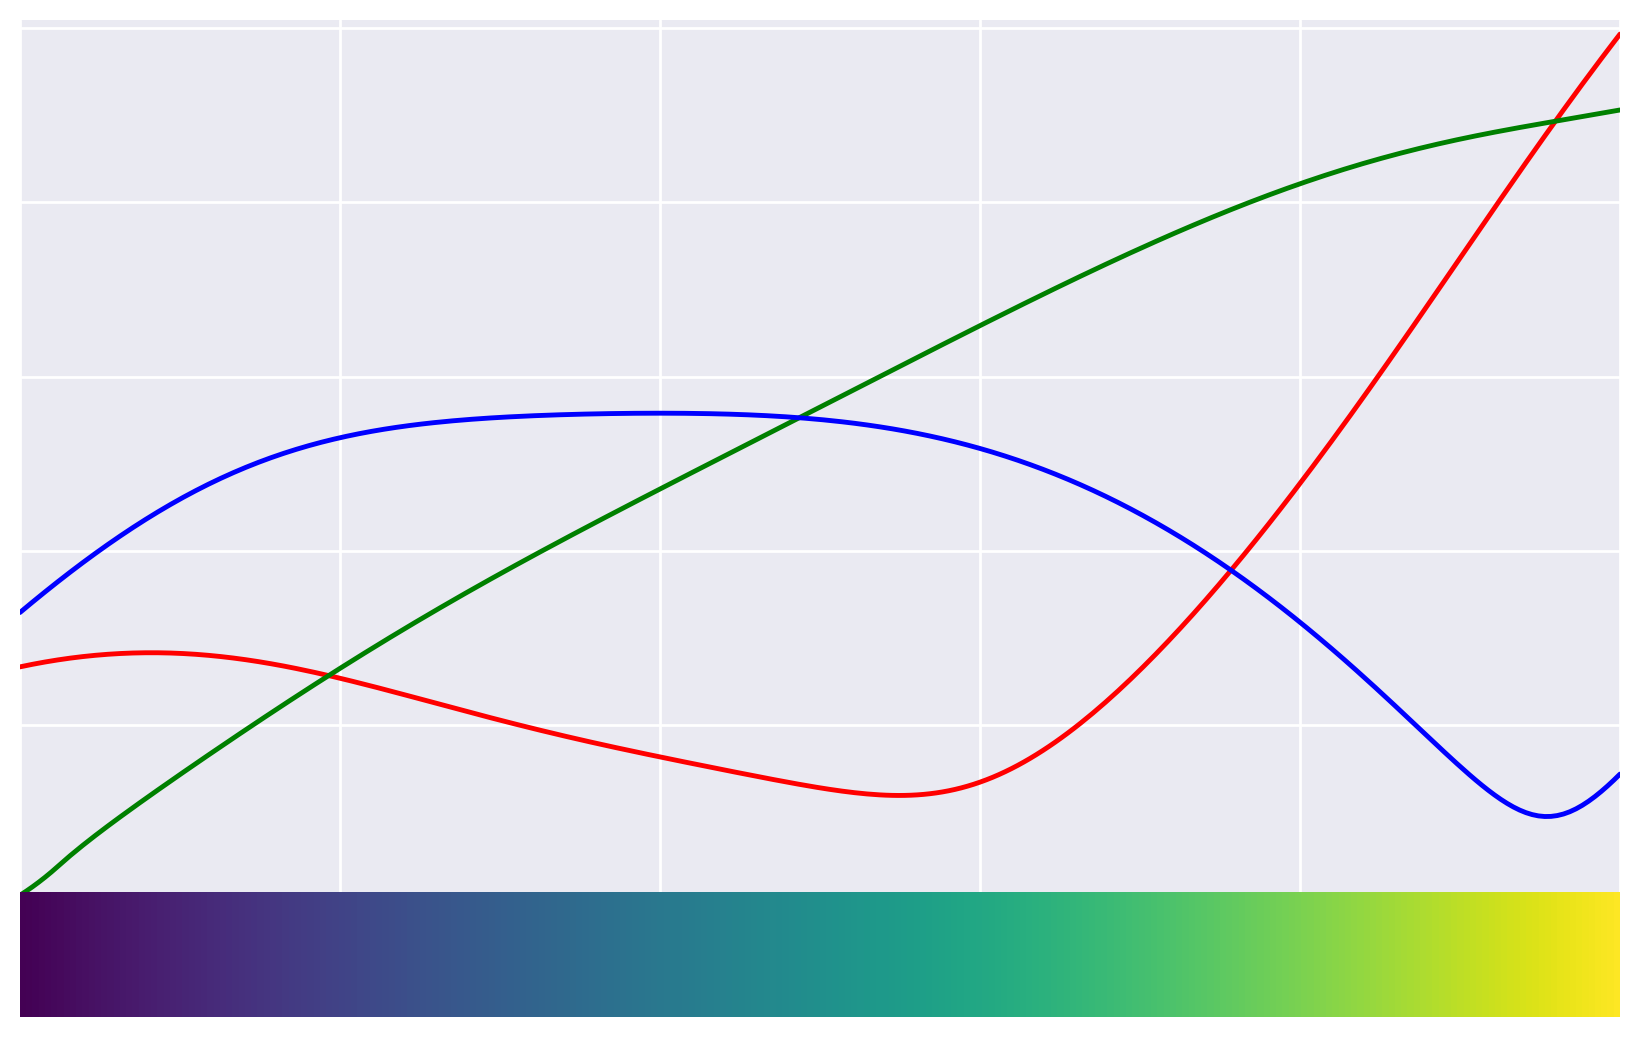

In [37]:
plot_rgb('viridis')

Let's also take a look at 'jet'.  For a long time, jet was the default colormap; part of this stems from the similairites between the API for matplotlib and matlab, long ago.  We'll explore some of the odd quirks in jet in another notebook.

<Figure size 1600x1100 with 0 Axes>

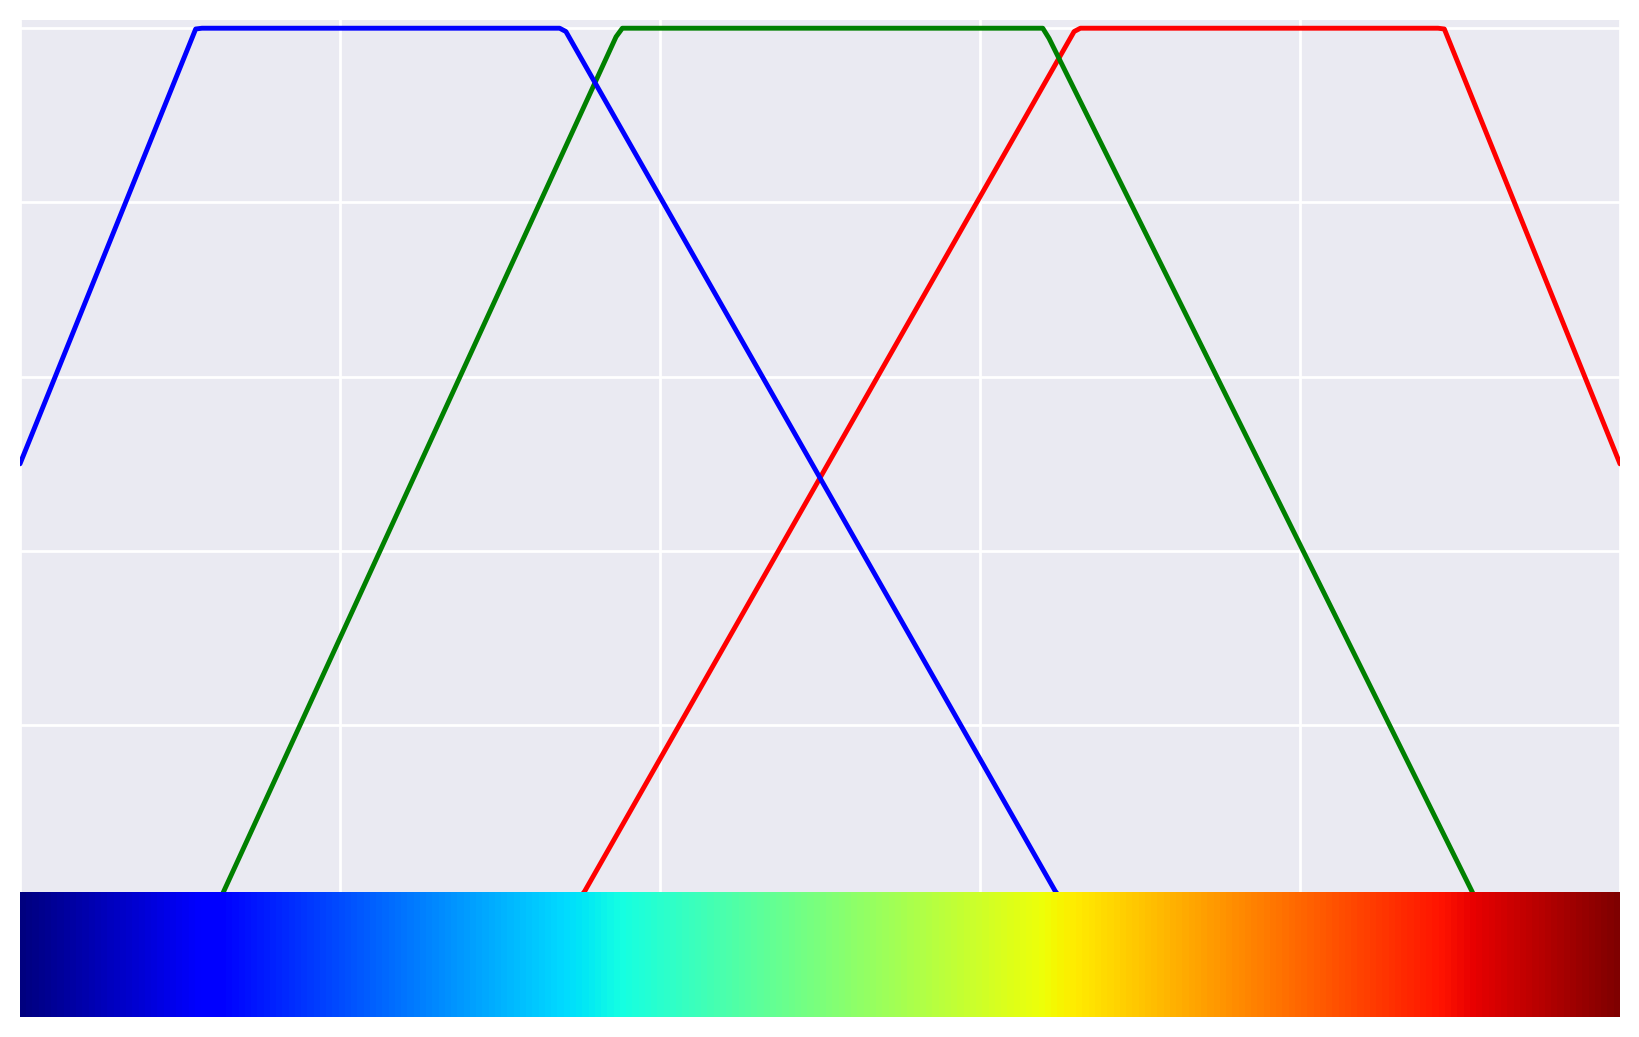

In [38]:
plot_rgb("jet")

This is the gray colormap, which just grows linearly from 0..1 simultaneously in all three channels.

<Figure size 1600x1100 with 0 Axes>

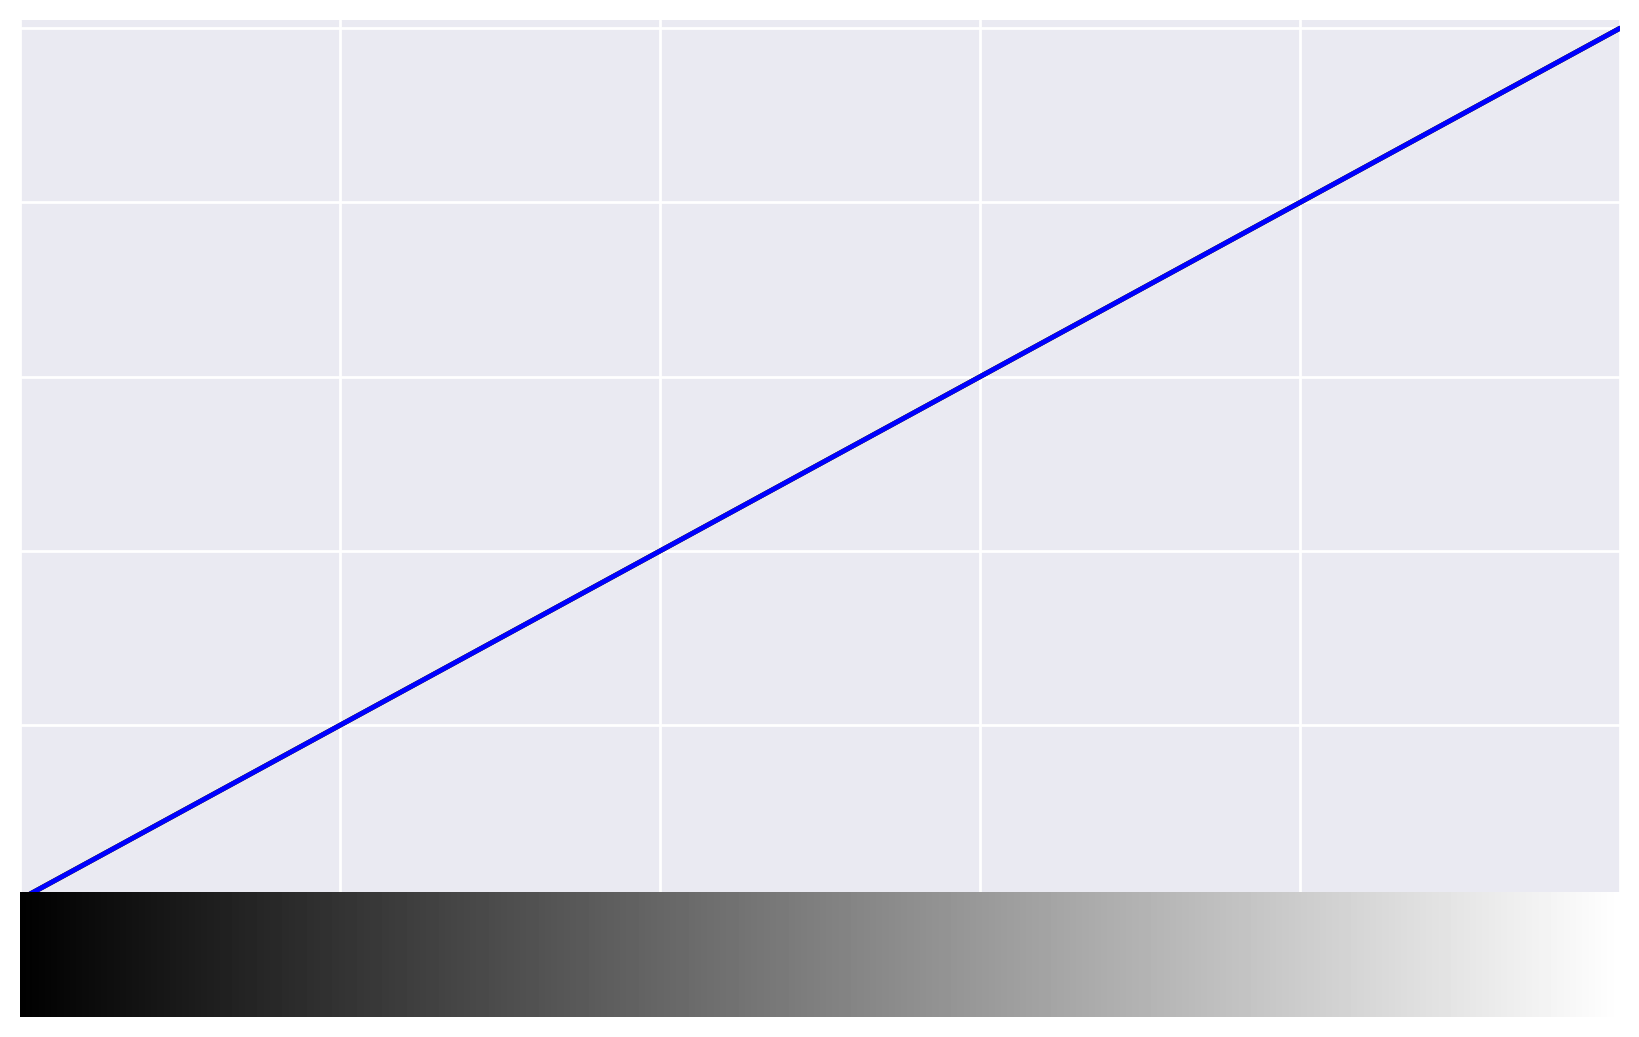

In [39]:
plot_rgb("gray")

This is a colormap called "GIST Stern."  According to https://gist.github.com/endolith/2719900 , this came from the Yorick package, and before that, IDL.  I used to use this one a lot in astronomy.  I'm not a huge fan anymore.

<Figure size 1600x1100 with 0 Axes>

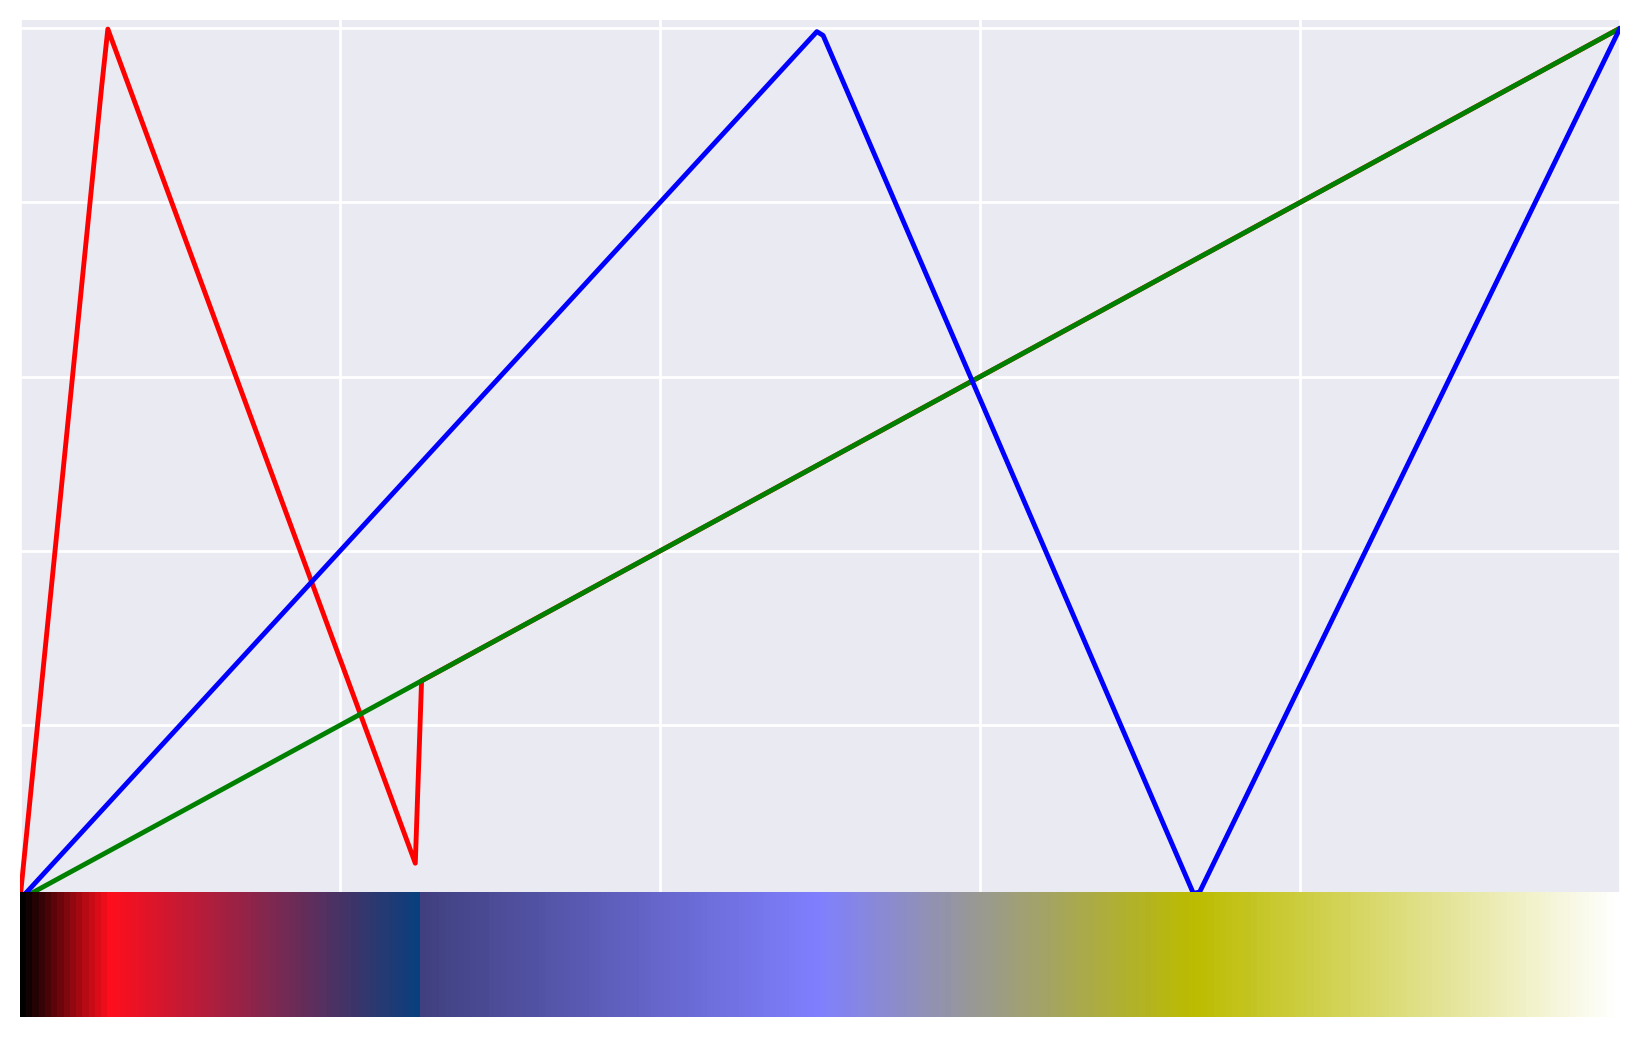

In [40]:
plot_rgb("gist_stern")

Don't use this colormap.  I mean, there might be reasons one could hazard to use it but ... I don't know of any good ones.

<Figure size 1600x1100 with 0 Axes>

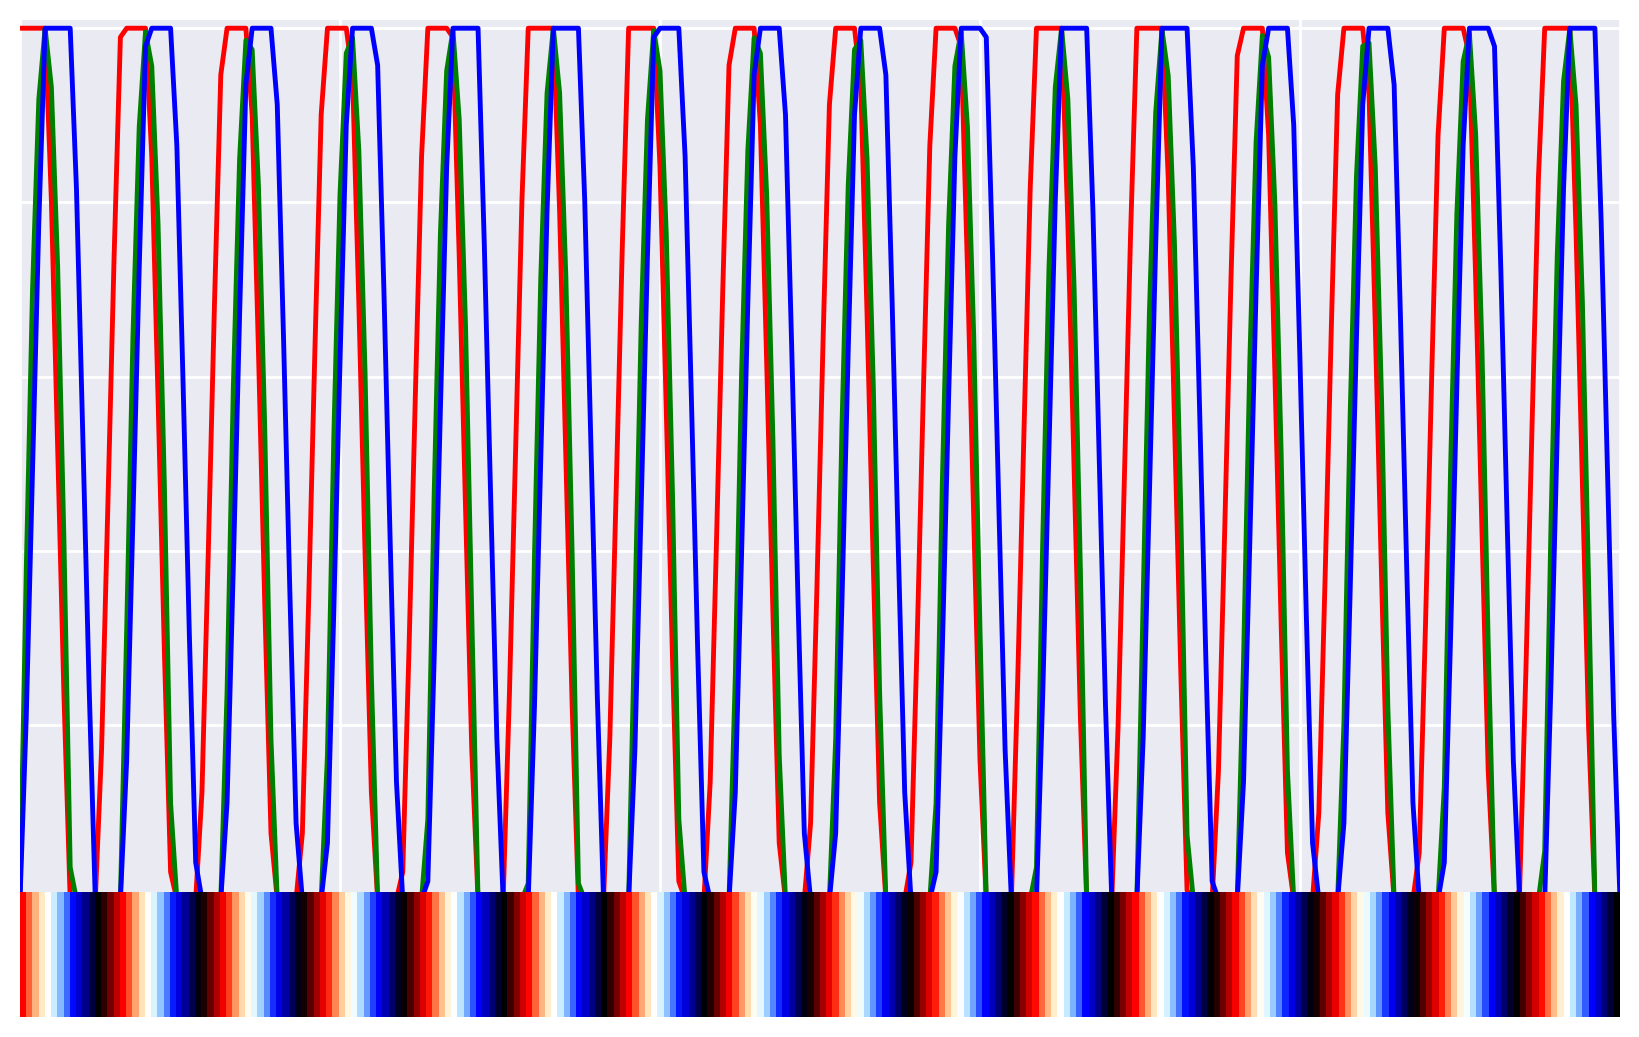

In [41]:
plot_rgb("flag")

Magma is another good, new colormap from matplotlib designed for accessibility and perceptual uniformity.

<Figure size 1600x1100 with 0 Axes>

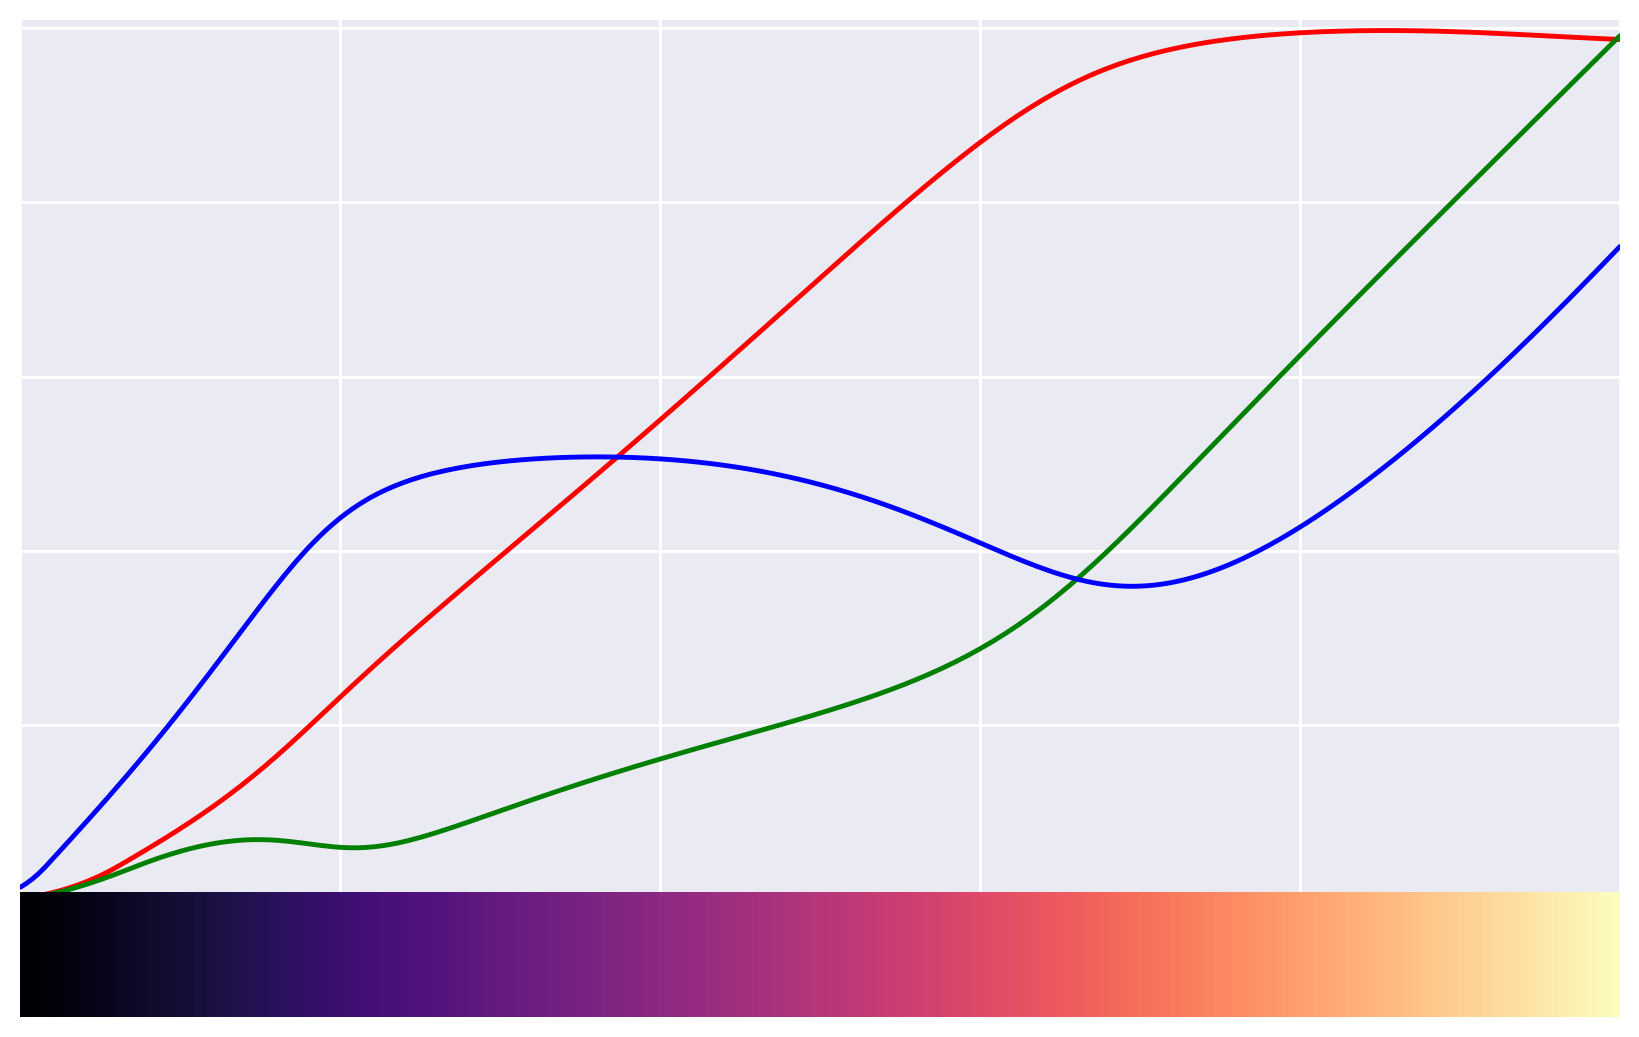

In [42]:
plot_rgb("magma")

## Palettes

We're going to experiment with color palettes, as well.  This will use the [palettable](https://jiffyclub.github.io/palettable/) library from Matt Davis.

We're going to talk about basically three different ways of thinking of palettes: qualitative (categorical), diverging, and sequential.

In general, qualitative are for situations where you wish to express different categories, diverging when you wish to express deviation from a baseline value, and sequential when the baseline is moved away from only in one direction.

In [54]:
import palettable

First, the qualitative colormaps.  Note how they don't work that well as continuous images!

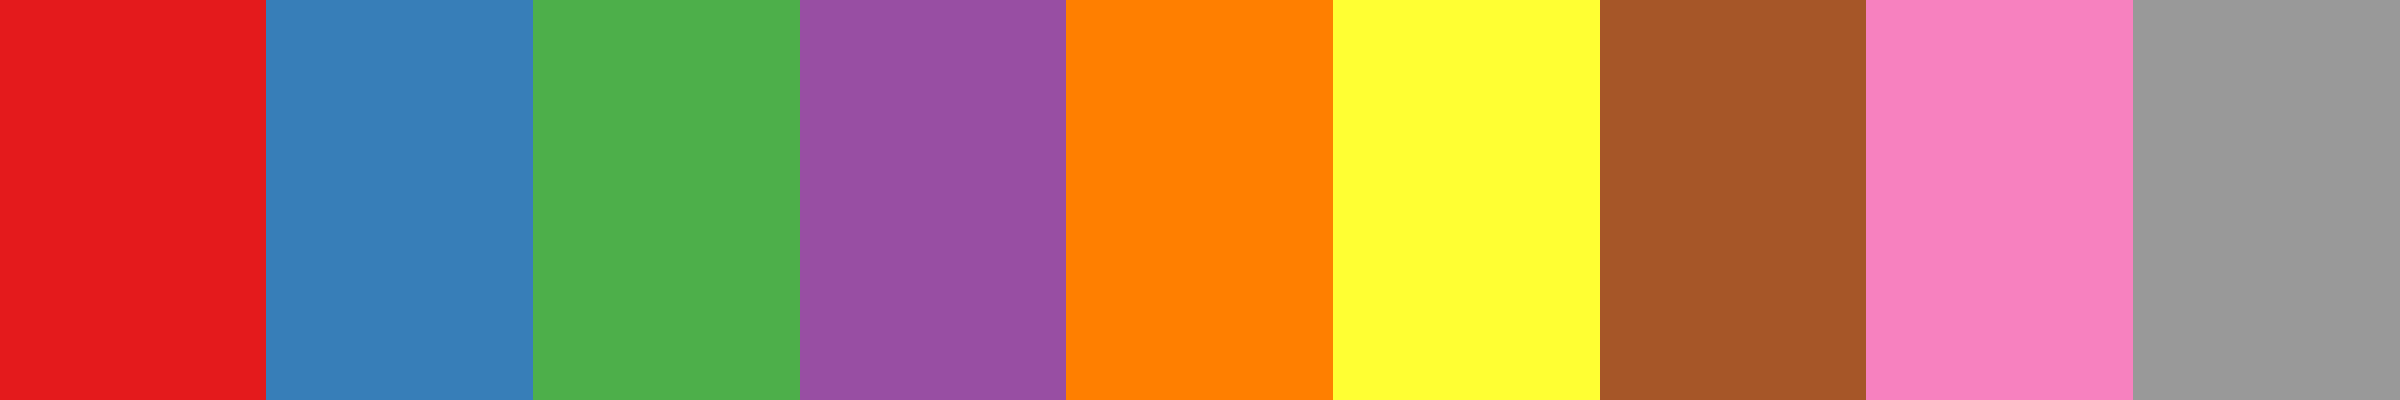

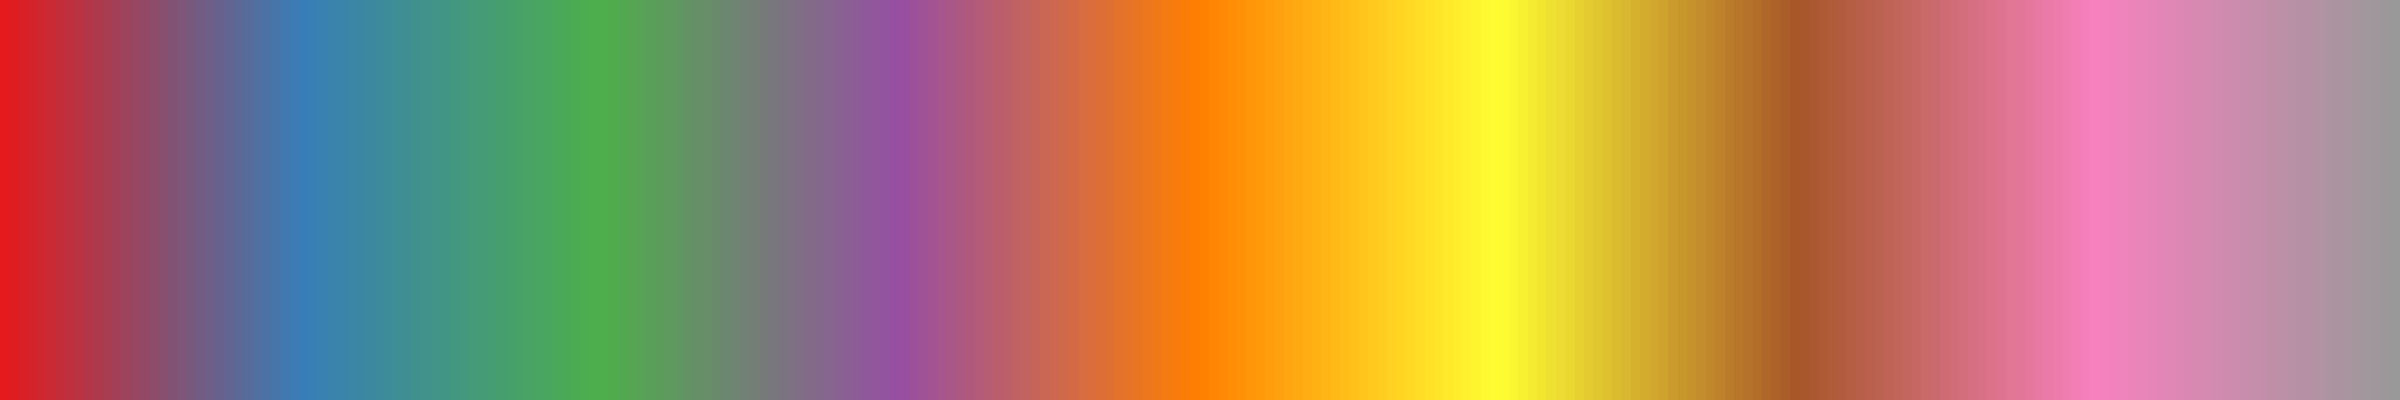

In [55]:
from palettable.colorbrewer.qualitative import Set1_9
Set1_9.show_discrete_image(size=(12,2))
Set1_9.show_continuous_image(size=(12,2))

Let's write some simple functions so that we can play with the colormaps via widgets.  We'll write one for each type of colormap.

In [56]:
def get_cb_diverging(name = "Spectral", number = 9):
    number = min(number, max(int(_) for _ in palettable.colorbrewer.COLOR_MAPS["Diverging"][name]))
    m = palettable.colorbrewer.get_map(name, map_type="diverging", number=number)
    m.show_discrete_image(size=(12,2))
    m.show_continuous_image(size=(12,2))

In [57]:
def get_cb_qualitative(name = "Set1", number = 9):
    number = min(number, max(int(_) for _ in palettable.colorbrewer.COLOR_MAPS["Qualitative"][name]))
    m = palettable.colorbrewer.get_map(name, map_type="qualitative", number=number)
    m.show_discrete_image(size=(12,2))
    m.show_continuous_image(size=(12,2))

In [58]:
def get_cb_sequential(name = "Blues", number = 9):
    number = min(number, max(int(_) for _ in palettable.colorbrewer.COLOR_MAPS["Sequential"][name]))
    m = palettable.colorbrewer.get_map(name, map_type="sequential", number=number)
    m.show_discrete_image(size=(12,2))
    m.show_continuous_image(size=(12,2))

As you look at these next few cells, note how things change with each colormap as well as with each count and type of colormap.

In [59]:
import ipywidgets

In [60]:
ipywidgets.interact(get_cb_diverging, name = list(palettable.colorbrewer.COLOR_MAPS["Diverging"].keys()),  number = (1, 12))

interactive(children=(Dropdown(description='name', index=8, options=('BrBG', 'PiYG', 'PRGn', 'PuOr', 'RdBu', '…

<function __main__.get_cb_diverging(name='Spectral', number=9)>

In [51]:
ipywidgets.interact(get_cb_qualitative, name = list(palettable.colorbrewer.COLOR_MAPS["Qualitative"].keys()),  number = (1, 12))

interactive(children=(Dropdown(description='name', index=5, options=('Accent', 'Dark2', 'Paired', 'Pastel1', '…

<function __main__.get_cb_qualitative(name='Set1', number=9)>

In [52]:
ipywidgets.interact(get_cb_sequential, name = list(palettable.colorbrewer.COLOR_MAPS["Sequential"].keys()),  number = (1, 12))

interactive(children=(Dropdown(description='name', options=('Blues', 'BuGn', 'BuPu', 'GnBu', 'Greens', 'Greys'…

<function __main__.get_cb_sequential(name='Blues', number=9)>

Finally, cubehelix is a nice colormap for when you need to print out and get the same perceptual look as when its viewed in color.

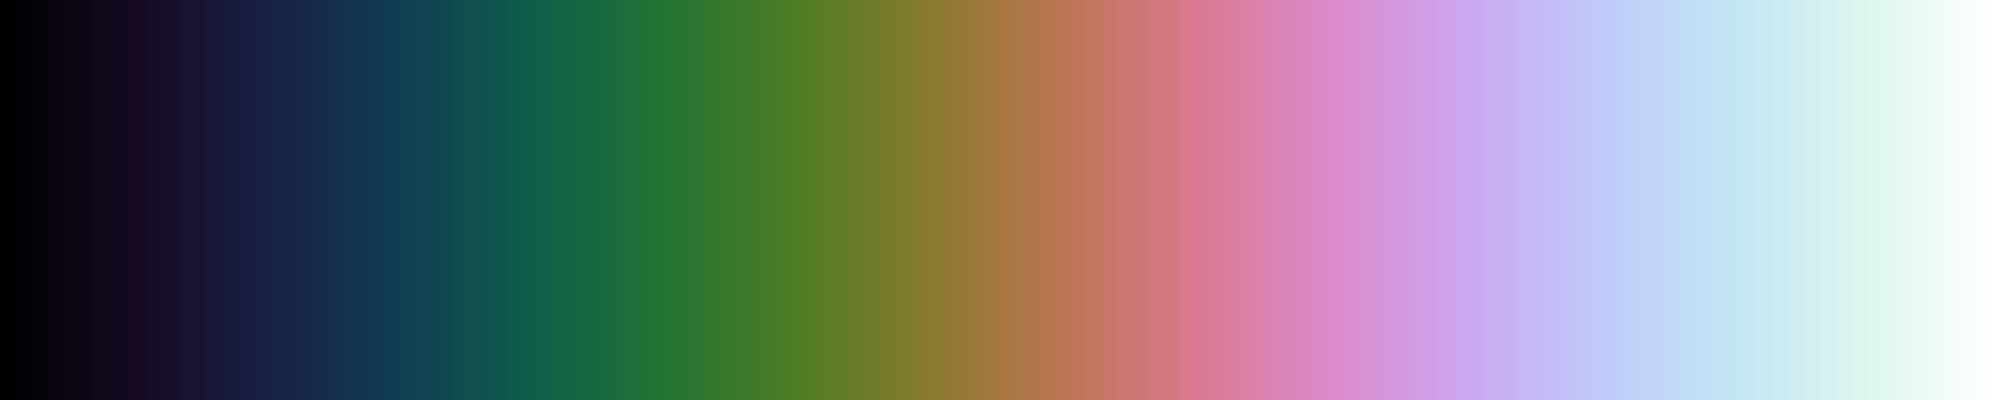

In [53]:
palettable.cubehelix.classic_16.show_continuous_image(size=(10,2))